In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install tensorflow
!pip install keras
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrad

In [2]:
data = pd.read_csv('converted.csv')
data['Inflation (Can)'] = data['Inflation (Can)'].shift(-30)
data = data.head(84*30)
data.drop(['Period'],axis=1,inplace=True)

In [4]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
y = scaled_data[:,0]
x = scaled_data[:,1:]
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
scaled_data = pca.fit_transform(x)

In [5]:
train_X = scaled_data[:72*30]
train_y = y[:72*30]
test_X = scaled_data[72*30:84*30]
test_y = y[72*30:84*30]

#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [4]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy import concatenate

In [13]:
para = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'tol' : [0.0001,0.0005,0.001],
    'C' : [0.8,1,1.2]
}
grid_ser = GridSearchCV(SVR(),scoring = 'neg_mean_squared_error',param_grid=para ,n_jobs =5,cv = 4,verbose=5)
grid_ser.fit(train_X,train_y)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 144 out of 144 | elapsed:   14.3s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=5,
             param_grid={'C': [0.8, 1, 1.2],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'tol': [0.0001, 0.0005, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=5)

In [14]:
from numpy import concatenate

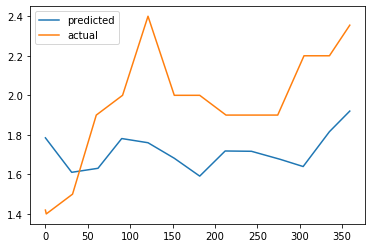

In [15]:
a = scaler.inverse_transform(
    concatenate(
        (grid_ser.best_estimator_.predict(test_X).reshape(360,-1),pca.inverse_transform(test_X)),
         axis=1
    )
)[:,0]

b = scaler.inverse_transform(
    concatenate(
        (test_y.reshape(360,-1),pca.inverse_transform(test_X)),
         axis=1
    )
)[:,0]

pyplot.plot(a, label='predicted')
pyplot.plot(b, label='actual')
pyplot.legend()
pyplot.show()

In [16]:
mean_squared_error(a,b)

0.11908419161045952

In [17]:
mean_absolute_error(a,b)

0.3181164277685724

In [20]:
from sklearn.metrics import r2_score
r2_score(a,b)

-24.98010052581348

In [ ]:
yhat = model.predict(test_X)
test_X1 = pca.inverse_transform(test_X.reshape((test_X.shape[0], test_X.shape[2])))
# invert scaling for forecast
inv_yhat = concatenate((yhat.reshape(12*30,1), test_X1), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y1, test_X1), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()

Epoch 1/7
22/22 - 6s - loss: 0.8745 - val_loss: 0.7171
Epoch 2/7
22/22 - 0s - loss: 0.8499 - val_loss: 0.6875
Epoch 3/7
22/22 - 0s - loss: 0.7349 - val_loss: 0.5350
Epoch 4/7
22/22 - 0s - loss: 0.5910 - val_loss: 0.3999
Epoch 5/7
22/22 - 0s - loss: 0.4948 - val_loss: 0.3513
Epoch 6/7
22/22 - 0s - loss: 0.4306 - val_loss: 0.3468
Epoch 7/7
22/22 - 0s - loss: 0.3838 - val_loss: 0.3574


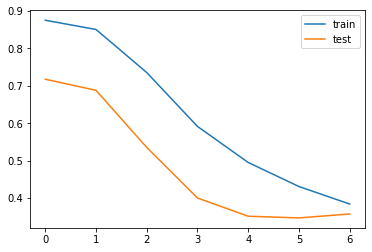

In [483]:
model = Sequential()

model.add(LSTM(128,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(16,return_sequences=True))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=7, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

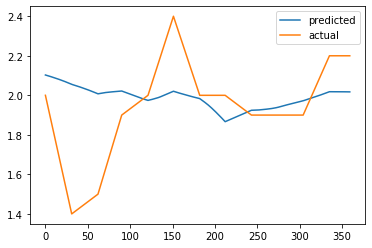

In [484]:
yhat = model.predict(test_X)
test_X1 = pca.inverse_transform(test_X.reshape((test_X.shape[0], test_X.shape[2])))
# invert scaling for forecast
inv_yhat = concatenate((yhat.reshape(12*30,1), test_X1), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y1, test_X1), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()

In [ ]:
yhat = model.predict(pred_X)
test_X1 = pred_X.reshape((pred_X.shape[0], pred_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat.reshape(13,1), test_X1), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y1 = pred_y.reshape((len(pred_y), 1))
inv_y = concatenate((test_y1, test_X1), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()

In [364]:
data = pd.read_csv('raw_data.csv')
data = data.drop(['Inflation (Can)','Period'],axis=1)

In [5]:
def data_sel(name):
    return pd.read_csv(name+'.csv')
data = data_sel('raw_data')

In [12]:
def lstm_lag(n):
    data = data_sel('raw_data')
    data['Inflation (Can)'] = data['Inflation (Can)'].shift(-1*n)
    data = data.head(84)
    data.drop(['Period'],axis=1,inplace=True)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    y = scaled_data[:,0]
    x = scaled_data[:,1:]
    from sklearn.decomposition import PCA
    pca = PCA(n_components=5)
    scaled_data = pca.fit_transform(x)

    train_X = scaled_data[:72]
    train_y = y[:72]
    test_X = scaled_data[72:84]
    test_y = y[72:84]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    model = Sequential()

    model.add(LSTM(128,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(64,return_sequences=True))
    model.add(LSTM(16,return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=3, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    #pyplot.plot(history.history['loss'], label='train')
    #pyplot.plot(history.history['val_loss'], label='test')
    #pyplot.legend()
    #pyplot.show()

    yhat = model.predict(test_X)
    test_X1 = pca.inverse_transform(test_X.reshape((test_X.shape[0], test_X.shape[2])))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat.reshape(12,1), test_X1), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    a = inv_yhat
    # invert scaling for actual
    test_y1 = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y1, test_X1), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    b = inv_y
    # calculate RMSE
    #rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    #print('Test RMSE: %.3f' % rmse)
    pyplot.plot(inv_yhat, label='predicted')
    pyplot.plot(inv_y, label='actual')
    pyplot.legend()
    pyplot.show()
    return mean_squared_error(a,b),mean_absolute_error(a,b)

In [13]:
def svm_lag(n):
    data = data_sel('raw_data')
    data['Inflation (Can)'] = data['Inflation (Can)'].shift(-1*n)
    data = data.head(84)
    data.drop(['Period'],axis=1,inplace=True)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    y = scaled_data[:,0]
    x = scaled_data[:,1:]
    from sklearn.decomposition import PCA
    pca = PCA(n_components=5)
    scaled_data = pca.fit_transform(x)

    train_X = scaled_data[:72]
    train_y = y[:72]
    test_X = scaled_data[72:84]
    test_y = y[72:84]

    #train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    #test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    para = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'tol' : [0.0001,0.0005,0.001,0.01,0.1],
    'C' : [0.1,0.5,1,2]
    }
    grid_ser = GridSearchCV(SVR(),scoring = 'neg_mean_squared_error',param_grid=para ,n_jobs =5,cv = 4,verbose=5)
    grid_ser.fit(train_X,train_y)
    print(grid_ser.best_params_)

    a = scaler.inverse_transform(
    concatenate(
    (grid_ser.best_estimator_.predict(test_X).reshape(12,-1),pca.inverse_transform(test_X)),
     axis=1
    )
    )[:,0]

    b = scaler.inverse_transform(
    concatenate(
    (test_y.reshape(12,-1),pca.inverse_transform(test_X)),
     axis=1
    )
    )[:,0]

    pyplot.plot(a, label='predicted')
    pyplot.plot(b, label='actual')
    pyplot.legend()
    pyplot.show()
    return mean_squared_error(a,b),mean_absolute_error(a,b)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 187 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 320 out of 320 | elapsed:    2.1s finished


{'C': 0.5, 'kernel': 'poly', 'tol': 0.0001}


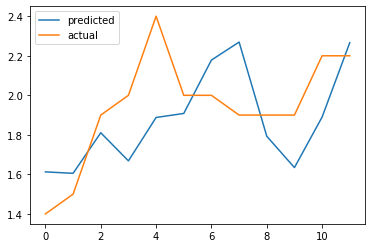

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  23 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  24 tasks      | elapsed:    0.0s


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [14]:
dicton = {'svm':[svm_lag(0),svm_lag(30),svm_lag(60),svm_lag(90)],
          'lstm':[lstm_lag(0),lstm_lag(30),lstm_lag(60),lstm_lag(90)]}

pd.DataFrame(dicton,index=['no lag','30 days','60 days','90 days'])